In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

from compressor.wavelet_compressor import WaveletCompressor

In [ ]:
# Load the.npy file
data = np.load('data/raw_temperature/tt0.npy')

coeff_arr, slices = pywt.coeffs_to_array(pywt.wavedec2(data, 'db1', level=3))

coeff_arr = pywt.threshold(coeff_arr, 0.39, mode='hard', substitute=0)

plt.imshow(np.ma.masked_where(coeff_arr==0, coeff_arr))
plt.colorbar(label='Coefficient Values')
plt.show()

rec_img = pywt.waverec2(pywt.array_to_coeffs(coeff_arr, slices, output_format='wavedec2'), 'db1')
plt.imshow(rec_img)

print(np.max(np.abs(rec_img - data)))
print(128 * 128 / np.count_nonzero(coeff_arr))

In [ ]:
from scipy.interpolate import griddata

data = np.load('data/raw_temperature/tt0.npy')
masked_arr = np.ma.masked_equal(data, 0)

x = np.arange(masked_arr.shape[1])
y = np.arange(masked_arr.shape[0])
xx, yy = np.meshgrid(x, y)
x1 = xx[~masked_arr.mask]
y1 = yy[~masked_arr.mask]

# Get the values of the non-masked elements
newarr = masked_arr.data[~masked_arr.mask]

# Interpolate the missing values
interpolated_arr = griddata((x1, y1), newarr, (xx, yy), method='linear')
plt.imshow(interpolated_arr)


In [ ]:
data1023 = np.load('data/raw_temperature/tt1023.npy')
plt.imshow(data1023)

In [ ]:
compressor = WaveletCompressor(0.5)
data = np.load('data/raw_temperature/tt0.npy')

data_comp = compressor.compress(data)
plt.imshow(pywt.coeffs_to_array(data_comp)[0])

In [ ]:
def convolve(arr: np.ma.masked_array, funk):
    for i in range(arr.shape[0]):
        for other_idxs, vec in np.ndenumerate(arr[i,:])

In [ ]:
wavelet = pywt.Wavelet('haar')
[phi, psi, x] = wavelet.wavefun(level=7)

data = np.load('data/raw_temperature/tt0.npy')
mask = (data == 0) | (data == None)

coeffs = []
dim = 2
for level in range(6, 0, -1):
    for axis in range(dim):
        coeff = convolve(wavelet.wavefun(level)[0][1:-1])
    

plt.scatter(x, phi)

In [ ]:
array = np.array([[[(0, 0, 0), (0, 0, 1)],[(0, 1, 0), (0, 1, 1)]],[[(1, 0, 0), (1, 0, 1)],[(1, 1, 0), (1, 1, 1)]]])

for other_idxs, elem in np.ndenumerate(array[0,:]):try
    print (array[:, other_idxs])

In [2]:
def convolve_masked(arr: np.ma.masked_array, funk):
    conv = np.ndarray((arr.shape[0], arr.shape[1] // funk.shape[0]))

    for i in range(arr.shape[0]):
        for k in range(arr.shape[1] // funk.shape[0]):
            sum = 0
            masked = 0

            for l in range(funk.shape[0]):
                j = k * funk.shape[0] + l
                sum += arr.data[i, j] * funk[l] * ~(mask[i, j])
                masked += arr.mask[i, j]

            if masked < funk.shape[0]:
                sum = sum * funk.shape[0] / (funk.shape[0] - masked)
            else:
                sum = 0
            
            conv[i, k] = sum / np.linalg.norm(funk, 2)**2
            
    return conv

def convolve(arr, funk):
    conv = np.ndarray((arr.shape[0], arr.shape[1] // funk.shape[0]))

    for i in range(arr.shape[0]):
        for k in range(arr.shape[1] // funk.shape[0]):
            sum = 0

            for l in range(funk.shape[0]):
                j = k * funk.shape[0] + l
                sum += arr.data[i, j] * funk[l]
            
            conv[i, k] = sum / np.linalg.norm(funk, 2)**2
            
    return conv

def substract_resized(arr, sub_arr):
    scale = arr.shape[0] // sub_arr.shape[0]
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            arr[i, j] -= sub_arr[i // scale, j // scale]

def add_resized(arr, sub_arr):
    scale = arr.shape[0] // sub_arr.shape[0]
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            arr[i, j] += sub_arr[i // scale, j // scale]

def decrease_level(arr: np.ma.masked_array, level):
    wavelet = pywt.Wavelet('haar')
    [phi, _, _] = wavelet.wavefun(level)

    coeffs = convolve_masked(np.ma.masked_array(arr, mask), phi[1:-1])
    coeffs2 = convolve(np.ma.masked_array(coeffs.transpose()), phi[1:-1]).transpose()
    substract_resized(arr, coeffs2)

    return coeffs2

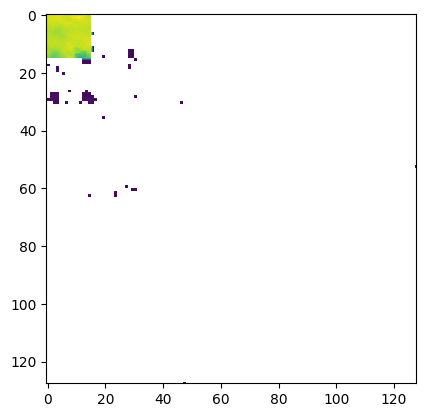

19.645083932853716


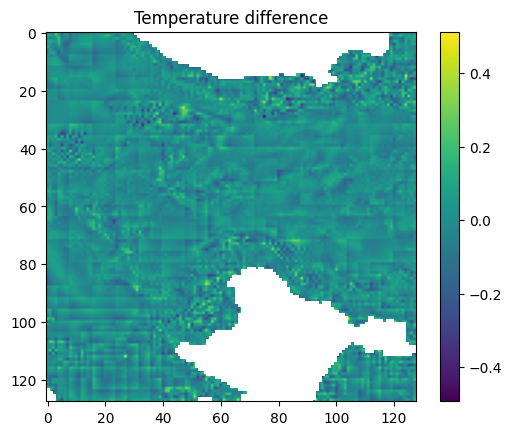

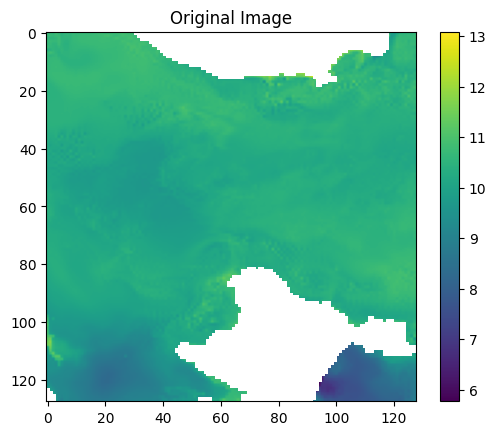

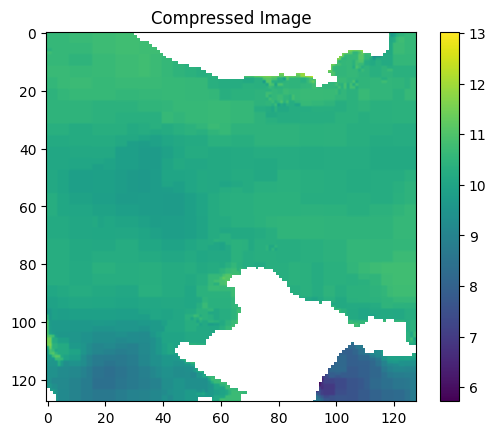

0.5131149394337449


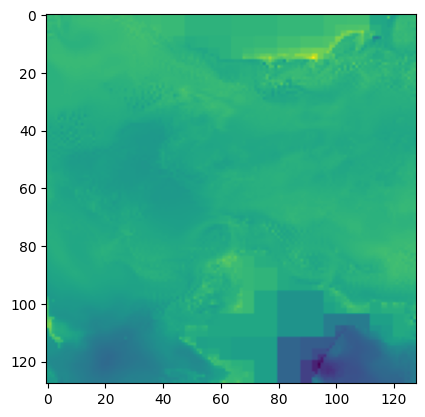

In [15]:
data = np.load('data/raw_temperature/tt875.npy')
mask = (data == 0) | (data == None)

coeffs = []
for level in range(6, 0, -1):
    coeffs.append(decrease_level(np.ma.masked_array(data, mask), level))

for coeff in coeffs:
    add_resized(data, coeff)

compressor = WaveletCompressor(0.5)
coeffs_comp = compressor.compress(data)

coeff_arr, slices = pywt.coeffs_to_array(coeffs_comp)
plt.imshow(np.ma.masked_where(coeff_arr==0, coeff_arr))
plt.show()

print(compressor.compression_coefficient(data, coeff_arr))
plt.imshow(np.ma.masked_array(np.load('data/raw_temperature/tt875.npy') - compressor.decompress(pywt.array_to_coeffs(coeff_arr, slices, 'wavedecn')), mask))
plt.colorbar()
plt.title('Temperature difference')
plt.show()

plt.imshow(np.ma.masked_array(np.load('data/raw_temperature/tt875.npy'), mask))
plt.colorbar()
plt.title('Original Image')
plt.show()

plt.imshow(np.ma.masked_array(compressor.decompress(pywt.array_to_coeffs(coeff_arr, slices, 'wavedecn')), mask))
plt.colorbar()
plt.title('Compressed Image')
plt.show()

print(np.max(np.abs(np.ma.masked_array(np.load('data/raw_temperature/tt875.npy') - compressor.decompress(pywt.array_to_coeffs(coeff_arr, slices, 'wavedecn')), mask))))

plt.imshow(data)
plt.show()